# Introduction



## What is outliers?

An outlier is an observation that lies an abnormal distance from other values in a random sample from a population. Sometimes it may be caused by measurement variability, but it could also be caused by some experiment errors. One example in which outliers could be common is the environmental science, where researchers need to measure numerous indicators that are sensitive to the smallest error in their measuring apparatus. Observations such as these could compremise the research result and leave researchers with meaningless findings if they are not taken out of the data set.

## Peirce's Criterion

Peirce's Criterion is the rules of eliminating outliers devised by Benjamin Peirce. It takes the form of the ratio of the maximum allowable deviation from the sample set’s mean to the standard deviation:$$R=\frac{|X_i-X_m|_{max}}{\sigma}$$

To implement this method:
1. Find the mean and sample standard deviation for the entire set.
1. Look up the value of R in a Peirce’s table that corresponds to the number of observations in your sample set. Begin by assuming one outlier, although you may repeat the process to discover more than one.
1. Use the formula $|X_i – X_m|_{max}= σ R$ to calculate the maximum allowable deviation.
1. Calculate the actual deviation of your potential outliers. $|X_i – X_m|$
1. Check if $|X_i – X_m| > |X_i – X_m|_{max}$, and if it is, eliminate that outlier.
1. Now assume two outliers, and go through step 2-5 again. Keep the original number of measurements as well as the original values of the standard deviation and mean.
1. If your calculations in step 6 give you another outlier, you can repeat the process. Assume an additional outlier each time through and use the original number of measurements, mean and standard deviation each time.
1. Once all questionable data has been tested, calculate the mean and standard deviation again for your final data set.

## Other Method of Outlier Identification

### Chauvenet's Criterion

Chauvenet's criterion is the rules of eliminating outliers devised by William Chauvenet. We can implement this method by creating an acceptable band of data around the mean, specifying any values that fall outside that band should be eliminated. The formula to calculate the band is: $$1-\frac{1}{2n}$$ where $n$ is the sample size. Normal distribution probabilities can be used to relate the formula to a maximum deviation from the mean:
$τ = \frac{|X_i – x̄|} {s}$. While Chauvenet's criterion is very similar to Peirce's criterion, it does not account for multiple outliers and only consider if a single observation could be spurious.

## FLUXNET 2015 Dataset

FLUXNET is a global network comprised of flux measuring towers that continuously collect and transmit environmental and meteorological information. Some of the information includes greenhouse gases, temperature, precipitation, and heat energy. The recently published 2015 dataset is comprised of 1500 site-year data from 212 sites around the globe measured in a half-hourly basis. The full version of the dataset is extensive in scale, but this project will only focus on data measured in May 2002.


# Method

### Load the Data
In this project, we will apply Peirce's Criterion on FLUXNET 2015 data set variables net ecosysytem exchange (NEE) and incoming shortwave radiation (SW<sub>in</sub>).

In [92]:
flux.df <- read.csv("https://ds-wm.github.io/course/atsa/data/FLX_US-Goo_FLUXNET2015_SUBSET_HH_2002-05_1-4.csv")
X <- flux.df$SW_IN_F
y <- flux.df$NEE_VUT_REF

### Implement Peirce's Criterion
The following implementation (peirce_dev) is taken from the Wikipedia page of Peirce's Criterion.

In [101]:
peirce_dev <- function(N, n, m) {
    if (N > 1) {
       Q = (n^(n/N) * (N-n)^((N-n)/N))/N
       Rnew = 1.0
       Rold = 0.0 
       while (abs(Rnew-Rold) > (N*2.0e-16)) {
           ldiv = Rnew^n
           if (ldiv == 0) {
              ldiv = 1.0e-6
           }
           Lamda = ((Q^N)/(ldiv))^(1.0/(N-n))
           x2 = 1.0 + (N-m-n)/n * (1.0-Lamda^2.0)
           if (x2 < 0) {
              x2 = 0
              Rold = Rnew
           } else {
              Rold = Rnew
              Rnew = exp((x2-1)/2.0)*(2*pnorm(sqrt(x2)/sqrt(2)*sqrt(2), lower=FALSE))
           }
       }
    } else {
       x2 = 0
    }
    return(x2)
}

The following implementation of outliers removal is taken and tanscribed from Python to R from the GePiSaT documentation Appendix A.2.

In [127]:
outliers <- function(X, y){
  model <- lm(y~X)
  N <- length(y)
  se <- (model$residuals)^2
  mse <- mean(se)
  x2 <- peirce_dev(N, 1, 2)
  d2 <- mse*x2
  n_index <- which(se>d2)
  n_found <- length(n_index)
  if (n_found==0){
    x2 <- peirce_dev(N, 2, 2)
    d2 <- mse*x2
    n_index <- which(se>d2)
    n_found <- length(n_index)
  }
  n = 1
  while (n <= n_found){
    n <- n+1
    x2 <- peirce_dev(N, n, 3)
    d2 <- mse*x2
    n_index <- which(se > d2)
    n_found <- length(n_index)
  }
  X <- X[-c(n_index)]
  y <- y[-c(n_index)]
  return (list('X'=X,'y'=y,'n_index'=n_index))
}

In [177]:
# Generate a list of outliers removed X, y, and the outliers indices n_index.
df<-outliers(X,y)
print(length(df$X))
print(length(df$n_index))

[1] 1440
[1] 47


# Results

Here we plot the NEE versus SW<sub>in</sub>, with red data points being the Peirce's outliers. We have identified 47 outliers in total.

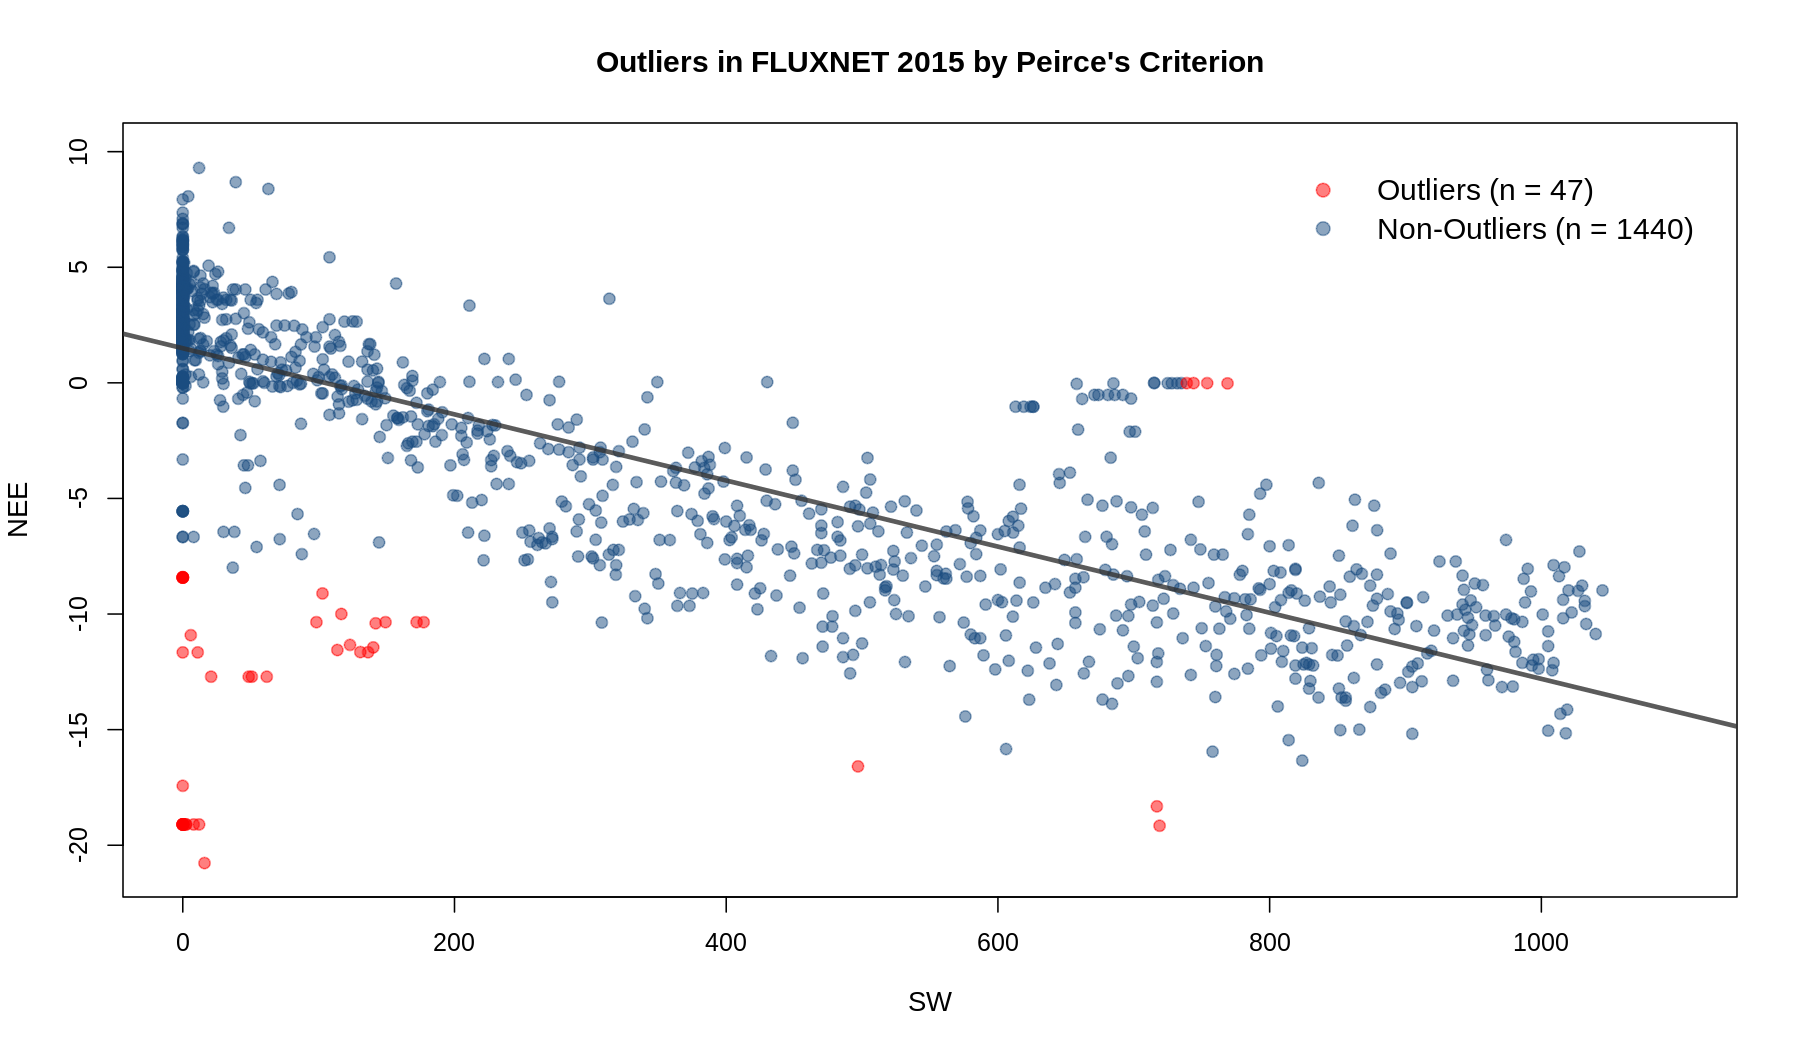

In [179]:
# Plot.
options(repr.plot.width = 12, repr.plot.height = 7, repr.plot.res = 150)

plot(
  pch = 19,
  col = rgb(red = 0.1, green = 0.3, blue = 0.5, alpha = 0.5),
  df$X,
  df$y,
  xlim = c(0, 1100), ylim = c(-21, 10),
  main = "Outliers in FLUXNET 2015 by Peirce's Criterion",
  xlab = "SW", ylab = "NEE",
  cex = 1, cex.lab = 1.1, cex.main = 1.2
)

points(
  pch = 19,
  X[df$n_index],
  y[df$n_index], 
  col = rgb(red = 1, green = 0, blue = 0, alpha = 0.5)
)

abline(
  model,
  lwd = 3,
  col = rgb(red = 0.2, green = 0.2, blue = 0.2, alpha = 0.8)
)

legend(x = 800, y = 10,
  legend = c("Outliers (n = 47)","Non-Outliers (n = 1440)"),
  pch = 19, 
  col = c(rgb(red = 1, green = 0, blue = 0, alpha = 0.5), rgb(red = 0.1, green = 0.3, blue = 0.5, alpha = 0.5)), 
  cex = 1.2,
  bty = 'n'
)

# Discussions and Conclusions

In this project, we applied Peirce's Criterion on the FLUXNET 2015 data set and identified outliers from net ecosysytem exchange (NEE) and incoming shortwave radiation (SW<sub>in</sub>). We used two functions to realize this implementation in R. The first function was taken from Peirce's Criterion's Wikipedia page, where implementations were shown in different languges. The second function was taken from the GePiSaT documentation. It was originally written in Python, and we transcribed the function into R and made a few changes to fit our purpose. Finally, we plotted the NEE versus SW<sub>in</sub> and highlighted the outliers. 

We found 47 outliers out of 1487 observations. In the plot above, we see that in some close clusters of data points, one part of them are identified as outliers while the other part remained in the data set. This is thought-provoking because they should be similar in values and the outliers have little more impact on the fitted values than their normal neighbors. 

From the plot we can see that there is a negative correlation between NEE and SW<sub>in</sub>, which means that as the incoming shortwave radiatoin increases, the net ecosystem exchange decreases. It is evidence that more energy from the sun improves the carbon absorbing ability of plants.

# References

“About the FLUXNET Network.” (2020) FLUXNET. Lawrence Berkeley National Laboratory. https://fluxnet.org/about/.


"Chauvenet’s Criterion." (2017) Statistics How To. https://www.statisticshowto.com/chauvenets-criterion/


Davis, T. (2021). Applied Time Series Analysis: Course Notebook - Student Copy Lesson 2. William & Mary, Williamsburg VA. Retrieved from https://colab.research.google.com/drive/1AtH8dXyTebnm4fl9Amx0o4s9VZ6Wzsqk?usp=sharing#scrollTo=cFE-C5JSr7Go.\n",


GePiSaT. (2019) Bitbucket.Org. https://bitbucket.org/labprentice/gepisat/


"Peirce’s Criterion." (2020) Wikipedia. Wikipedia contributors.  https://en.wikipedia.org/wiki/Peirce%27s_criterion#R_code
